# Exercise 4.4

As 2 time series data sequences usually vary in lengths and have local phase shifts (for example, it is not
straight forward to use popular distance metrics such as Euclidean distance on time series data. Dynamic
Time Warping (DTW)[8][9] is a similarity measuring technique often used for the above described scenarios.
Simple classifiers such as K-Nearest Neighbors can achieve high accuracy while using DTW as a
distance metric for classifying/clustering time series data.
The following tutorial applies DTW on some of the selected derived features from the activity recognition
data set.
https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/
master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal

#imports for DTW
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

In [31]:
plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print ('\r', self,end=" ")
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)
        

### Part A
Apply the same technique on raw data (pre-processed with filters) and compare it with the results
based on the derived features.

First Let's work on ALREADY pre-processed raw data (body-acc data) <br/>

#### Comparing betweeen recreation and derived feature (tBodyAcc-Mean X axis)

In [32]:
#initialise KnnDTW for DTW calculations later
m=KnnDtw()
#import data
body_acc_x = pd.read_csv(".\\UCI HAR Dataset\\train\\Inertial Signals\\body_acc_x_train.txt", header=None, sep='\s+')
df_x_train = pd.read_csv(".\\UCI HAR Dataset\\train\\X_train.txt", header=None, sep='\s+')
total_acc_x = pd.read_csv(".\\UCI HAR Dataset\\train\\Inertial Signals\\total_acc_x_train.txt", header=None, sep='\s+')


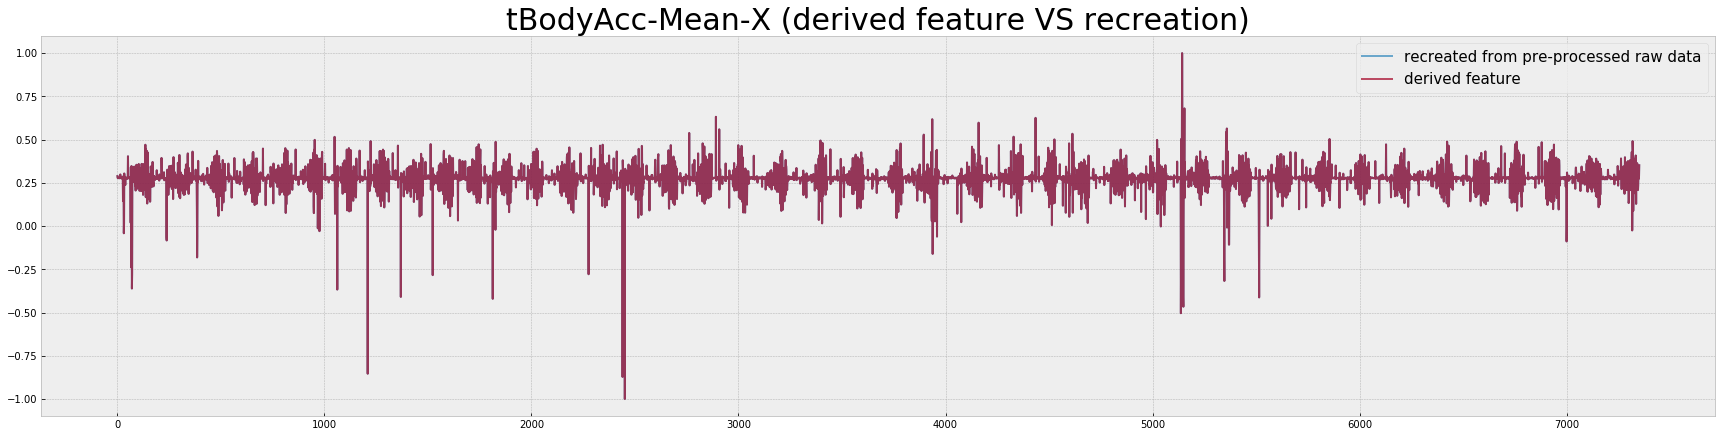

Distance betweeen recreation and derived feature for tBodyAcc-Mean-X is:  5.990437230929272e-05


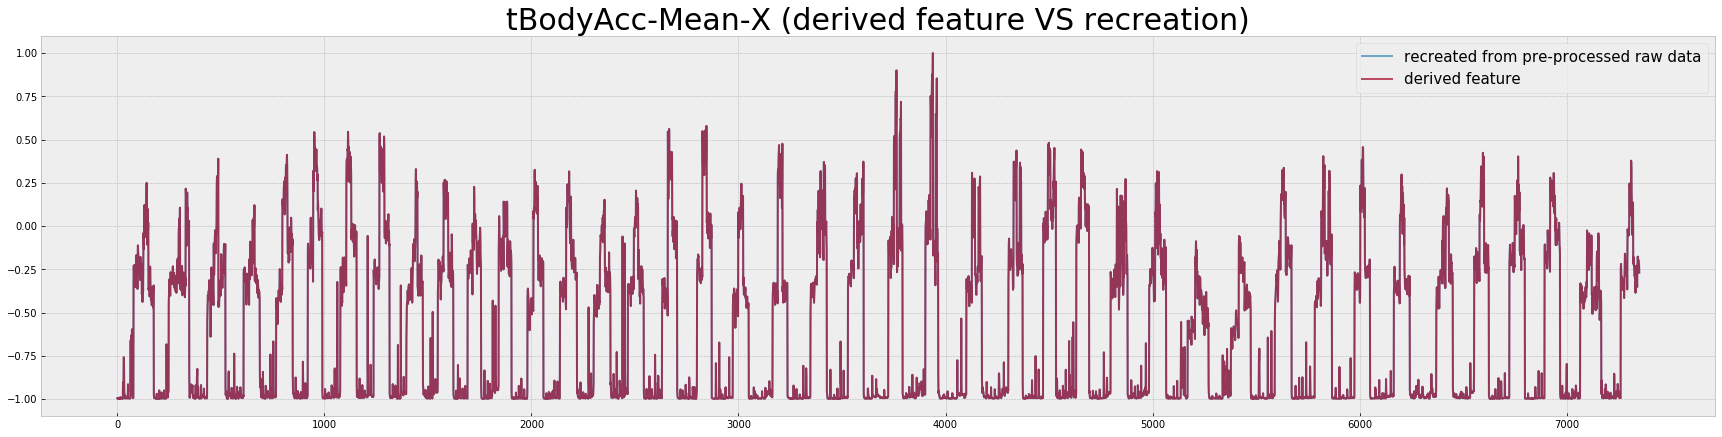

Distance betweeen recreation and derived feature for tBodyAcc-Std-X is:  5.263854535071243e-05


In [72]:
#recreate the derived feature from pre-processed raw data
mean_x = body_acc_x.mean(axis=1)
## normalize the mean betweeen 1 and -1
norm_mean_x = np.array([(2*(i-min(mean_x))/(max(mean_x)-min(mean_x)))-1 for i in mean_x])
tBodyAccMean_x = df_x_train.iloc[:,0] #tBodyAcc-Mean for X axis is in the first column
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(norm_mean_x,alpha=0.7,label="recreated from pre-processed raw data")
plt.plot(tBodyAccMean_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Mean-X (derived feature VS recreation)',fontsize=30)
plt.show()
distance = m._dtw_distance(norm_mean_x,tBodyAccMean_x)
print("Distance betweeen recreation and derived feature for tBodyAcc-Mean-X is: ",distance)

#recreate the derived feature from pre-processed raw data
std_x = body_acc_x.std(axis=1)
## normalize the mean betweeen 1 and -1
norm_std_x = np.array([(2*(i-min(std_x))/(max(std_x)-min(std_x)))-1 for i in std_x])
tBodyAccStd_x = df_x_train.iloc[:,3] #tBodyAcc-Mean for X axis is in the first column
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(norm_std_x,alpha=0.7,label="recreated from pre-processed raw data")
plt.plot(tBodyAccStd_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Std-X (derived feature VS recreation)',fontsize=30)
plt.show()
distance = m._dtw_distance(norm_std_x,tBodyAccStd_x)
print("Distance betweeen recreation and derived feature for tBodyAcc-Std-X is: ",distance)

Now, let's work on raw data that is not pre-processed (total-acc data) <br/>
We'll start with feature: tBodyAcc-Mean-X

In [48]:
#prepare data to filter
data=np.concatenate((total_acc_x.iloc[0,:].values,total_acc_x.iloc[1,:].values))
for i in range(2,total_acc_x.shape[0]):
    data=np.concatenate((data,total_acc_x.iloc[i,:].values))

# Low pass filter
b,a = scipy.signal.butter(N=3,Wn=0.012,btype='low')
low_pass_total_acc_x = scipy.signal.lfilter(b,a,data) 
low_pass_total_acc_x = low_pass_total_acc_x.reshape(body_acc_x.shape)
# High Pass filter
b,a = scipy.signal.butter(N=3,Wn=0.012,btype='high')
high_pass_total_acc_x = scipy.signal.lfilter(b,a,data) 
high_pass_total_acc_x = high_pass_total_acc_x.reshape(body_acc_x.shape)

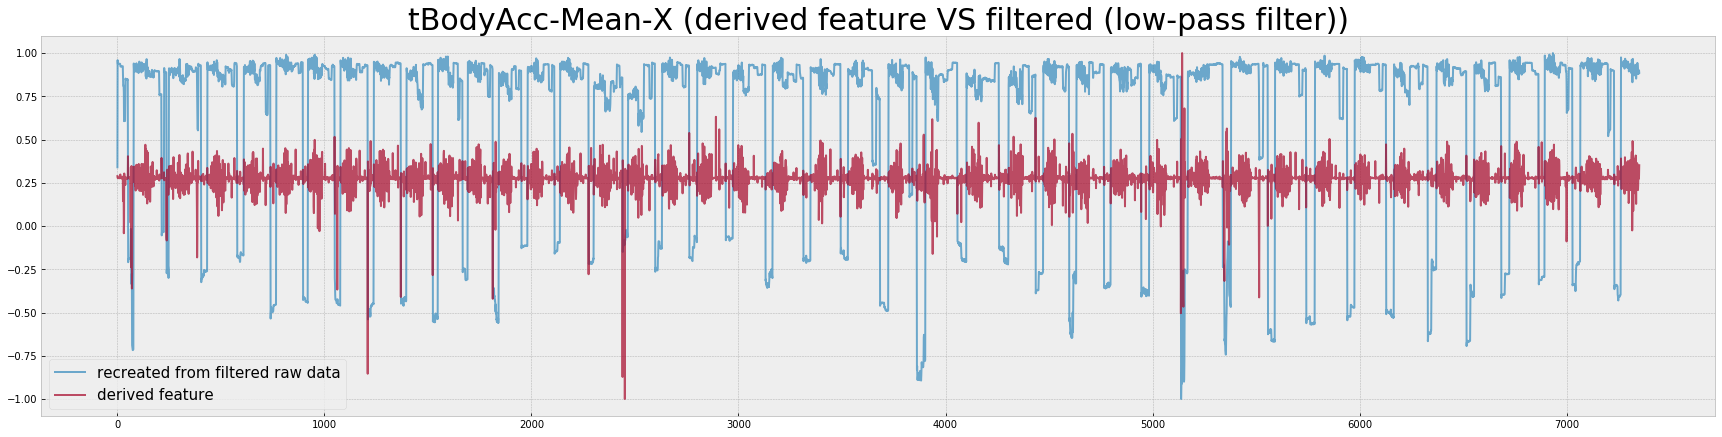

Distance betweeen low-pass filtered and derived feature for tBodyAcc-Mean-X is:  2889.9591682920104


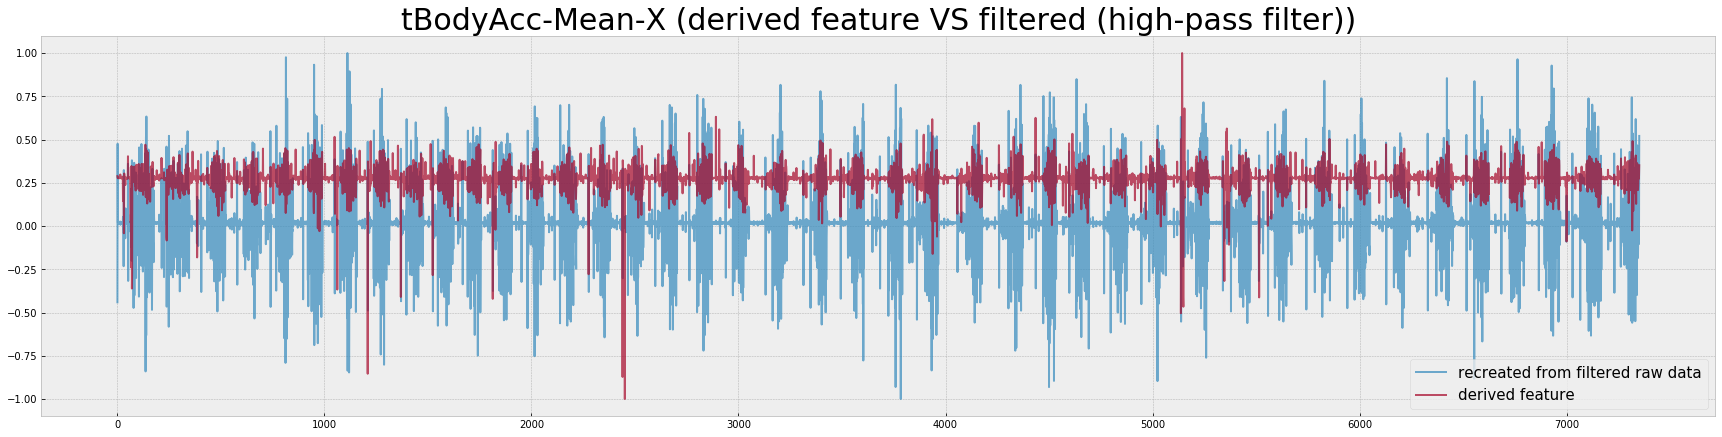

Distance betweeen high-pass filtered and derived feature for tBodyAcc-Mean-X is:  1029.374550422261


In [46]:
# derived feature to compare against
tBodyAccMean_x = df_x_train.iloc[:,0] #tBodyAcc-Mean for X axis is in the first column

#calculate the low pass filtered data to get derived data
low_pass_mean_x = low_pass_total_acc_x.mean(axis=1)
## normalize the mean betweeen 1 and -1
low_pass_norm_mean_x = np.array([(2*(i-min(low_pass_mean_x))/(max(low_pass_mean_x)-min(low_pass_mean_x)))-1 for i in low_pass_mean_x])
# get the derived feature to compare against
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(low_pass_norm_mean_x,alpha=0.7,label="recreated from filtered raw data")
plt.plot(tBodyAccMean_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Mean-X (derived feature VS filtered (low-pass filter))',fontsize=30)
plt.show()
distance = m._dtw_distance(low_pass_norm_mean_x,tBodyAccMean_x)
print("Distance betweeen low-pass filtered and derived feature for tBodyAcc-Mean-X is: ",distance)


#calculate the high pass filtered data to get derived data
high_pass_mean_x = high_pass_total_acc_x.mean(axis=1)
## normalize the mean betweeen 1 and -1
high_pass_norm_mean_x = np.array([(2*(i-min(high_pass_mean_x))/(max(high_pass_mean_x)-min(high_pass_mean_x)))-1 for i in high_pass_mean_x])
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(high_pass_norm_mean_x,alpha=0.7,label="recreated from filtered raw data")
plt.plot(tBodyAccMean_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Mean-X (derived feature VS filtered (high-pass filter))',fontsize=30)
plt.show()
distance = m._dtw_distance(high_pass_norm_mean_x,tBodyAccMean_x)
print("Distance betweeen high-pass filtered and derived feature for tBodyAcc-Mean-X is: ",distance)

Standard Deviation

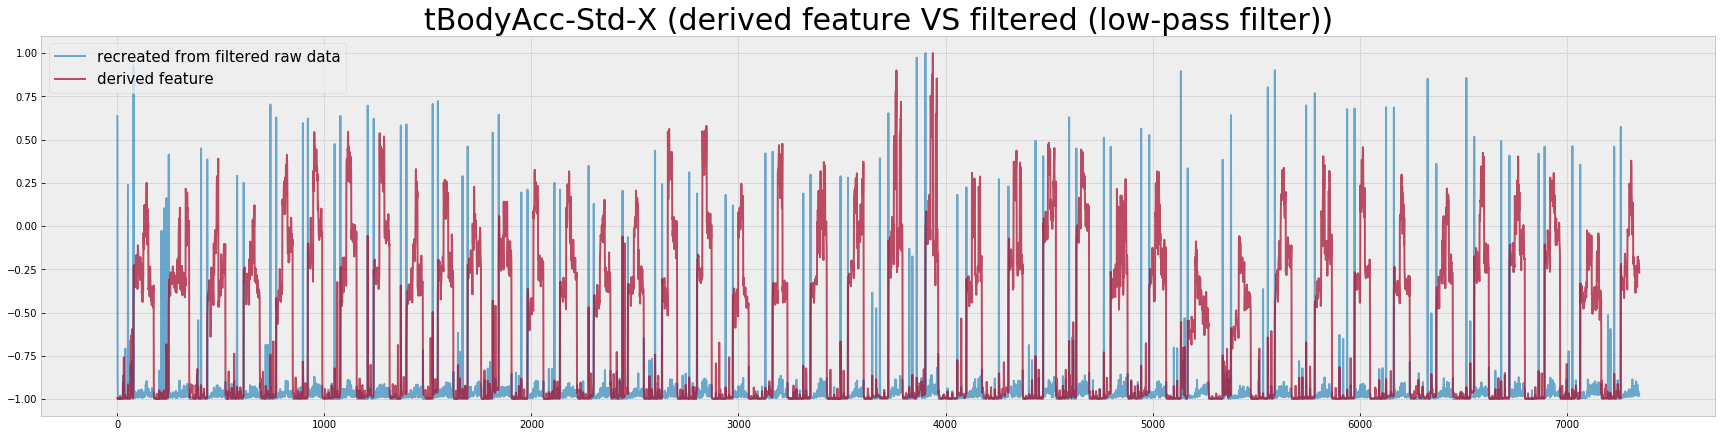

Distance betweeen low-pass filtered and derived feature for tBodyAcc-Mean-X is:  1308.9027152116714


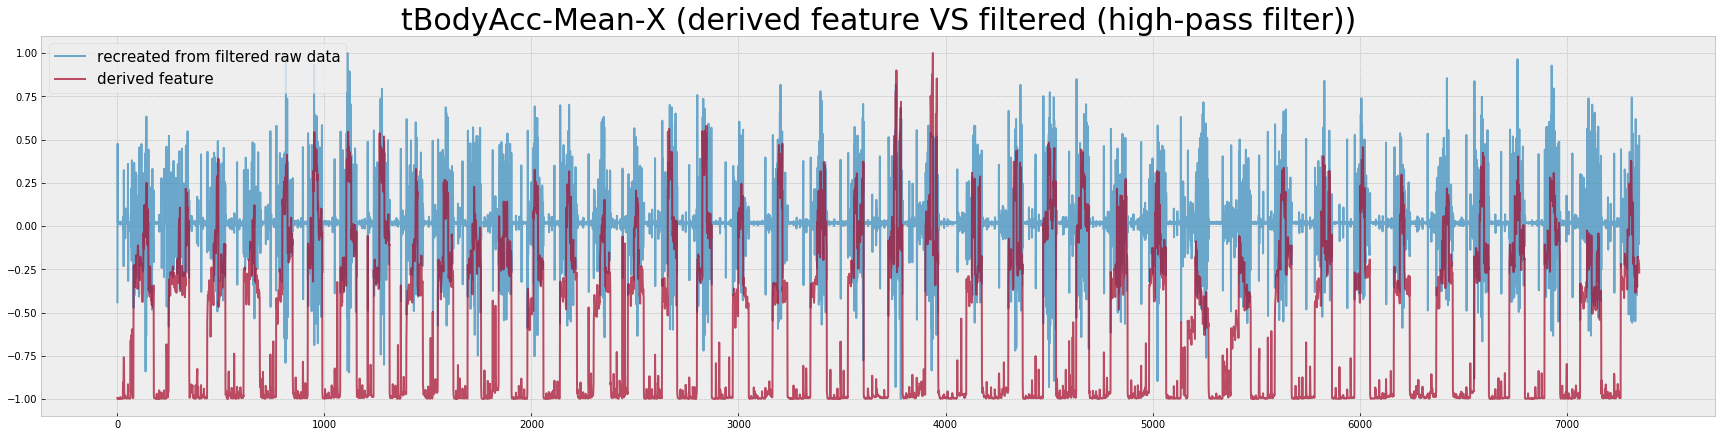

Distance betweeen high-pass filtered and derived feature for tBodyAcc-Mean-X is:  2030.4576307389168


In [50]:
# derived feature to compare against
tBodyAccStd_x = df_x_train.iloc[:,3] #tBodyAcc-Mean for X axis is in the 4th column

#calculate the low pass filtered data to get derived data
low_pass_std_x = low_pass_total_acc_x.std(axis=1)
## normalize the mean betweeen 1 and -1
low_pass_norm_std_x = np.array([(2*(i-min(low_pass_std_x))/(max(low_pass_std_x)-min(low_pass_std_x)))-1 for i in low_pass_std_x])
# get the derived feature to compare against
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(low_pass_norm_std_x,alpha=0.7,label="recreated from filtered raw data")
plt.plot(tBodyAccStd_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Std-X (derived feature VS filtered (low-pass filter))',fontsize=30)
plt.show()
distance = m._dtw_distance(low_pass_norm_std_x,tBodyAccStd_x)
print("Distance betweeen low-pass filtered and derived feature for tBodyAcc-Std-X is: ",distance)


#calculate the high pass filtered data to get derived data
high_pass_std_x = high_pass_total_acc_x.mean(axis=1)
## normalize the mean betweeen 1 and -1
high_pass_norm_std_x = np.array([(2*(i-min(high_pass_std_x))/(max(high_pass_std_x)-min(high_pass_std_x)))-1 for i in high_pass_std_x])
fig, ax = plt.subplots(figsize=(30,7))
plt.plot(high_pass_norm_std_x,alpha=0.7,label="recreated from filtered raw data")
plt.plot(tBodyAccStd_x,alpha=0.7,label="derived feature")
plt.legend(prop={'size':15})
plt.title('tBodyAcc-Mean-X (derived feature VS filtered (high-pass filter))',fontsize=30)
plt.show()
distance = m._dtw_distance(high_pass_norm_std_x,tBodyAccStd_x)
print("Distance betweeen high-pass filtered and derived feature for tBodyAcc-Std-X is: ",distance)

In [55]:
high_pass_norm_std_x[0]

-0.440762421737782

In [56]:
type(high_pass_norm_std_x)

numpy.ndarray

### Part B
Plot the yearly temperature for the following countries: Norway, Finland, Singapore and Cambodia.
Use DTW to measure the similarities between the temperature data of these countries and reflect on
the results.

In [43]:
m=KnnDtw()
# data imports
GlobalLandTempByCountry = pd.read_csv(".\\climate-change-earth-surface-temperature-data\\GlobalLandTemperaturesByCountry.csv", sep=',')
GlobalLandTempByMajorCity = pd.read_csv(".\\climate-change-earth-surface-temperature-data\\GlobalLandTemperaturesByMajorCity.csv", sep=',')
GlobalLandTempByState = pd.read_csv(".\\climate-change-earth-surface-temperature-data\\GlobalLandTemperaturesByState.csv", sep=',')
GlobalTemp = pd.read_csv(".\\climate-change-earth-surface-temperature-data\\GlobalTemperatures.csv", sep=',')

c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\jing yun\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


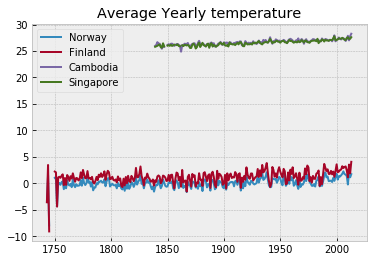

DTW Difference btweeen countries is: 
              Cambodia      Finland       Norway    Singapore
Cambodia      0.000000  3813.756500  3991.848583    23.042750
Finland    3813.756500     0.000000   126.774333  3792.487167
Norway     3991.848583   126.774333     0.000000  3970.579250
Singapore    23.042750  3792.487167  3970.579250     0.000000


In [71]:
### need to average by year ###
mask_norway = [GlobalLandTempByCountry.Country=="Norway"]
NorwayTemp = GlobalLandTempByCountry[np.logical_and.reduce(mask_norway)]
NorwayTemp.loc[:,'year'] = pd.DatetimeIndex(NorwayTemp['dt'],yearfirst=True).year
# get mean temperature by year
NorwayTemp.loc[:, 'AverageYearlyTemp'] = NorwayTemp.groupby(NorwayTemp.year)['AverageTemperature'].transform('mean')
NorwayYearlyTemp = NorwayTemp.loc[:,['AverageYearlyTemp','year']]
NorwayYearlyTemp = NorwayYearlyTemp.drop_duplicates()
plt.plot(NorwayYearlyTemp.year,NorwayYearlyTemp.AverageYearlyTemp, label='Norway')
#plt.title("Norway Temperature")
#plt.show()
mask_finland = [GlobalLandTempByCountry.Country=="Finland"]
FinlandTemp = GlobalLandTempByCountry[np.logical_and.reduce(mask_finland)]
FinlandTemp.loc[:,'year'] = pd.DatetimeIndex(FinlandTemp['dt'],yearfirst=True).year
#get mean temp by year
FinlandTemp.loc[:, 'AverageYearlyTemp'] = FinlandTemp.groupby(FinlandTemp.year)['AverageTemperature'].transform('mean')
FinlandYearlyTemp = FinlandTemp.loc[:,['AverageYearlyTemp','year']]
FinlandYearlyTemp = FinlandYearlyTemp.drop_duplicates()
plt.plot(FinlandYearlyTemp.year,FinlandYearlyTemp.AverageYearlyTemp, label='Finland')
#plt.title("Finland Temperature")
#plt.show()
mask_cambodia = [GlobalLandTempByCountry.Country=="Cambodia"]
CambodiaTemp = GlobalLandTempByCountry[np.logical_and.reduce(mask_cambodia)]
CambodiaTemp.loc[:,'year'] = pd.DatetimeIndex(CambodiaTemp['dt'],yearfirst=True).year
CambodiaTemp.loc[:, 'AverageYearlyTemp'] = CambodiaTemp.groupby(CambodiaTemp.year)['AverageTemperature'].transform('mean')
CambodiaYearlyTemp = CambodiaTemp.loc[:,['AverageYearlyTemp','year']]
CambodiaYearlyTemp = CambodiaYearlyTemp.drop_duplicates()
plt.plot(CambodiaYearlyTemp.year,CambodiaYearlyTemp.AverageYearlyTemp, label='Cambodia')
#plt.title("Cambodia Temperature")
#plt.show()
mask_sg = [GlobalLandTempByCountry.Country=="Singapore"]
SingaporeTemp = GlobalLandTempByCountry[np.logical_and.reduce(mask_sg)]
SingaporeTemp.loc[:,'year'] = pd.DatetimeIndex(SingaporeTemp['dt'],yearfirst=True).year
SingaporeTemp.loc[:, 'AverageYearlyTemp'] = SingaporeTemp.groupby(SingaporeTemp.year)['AverageTemperature'].transform('mean')
SingaporeYearlyTemp = SingaporeTemp.loc[:,['AverageYearlyTemp','year']]
SingaporeYearlyTemp = SingaporeYearlyTemp.drop_duplicates()
plt.plot(SingaporeYearlyTemp.year,SingaporeYearlyTemp.AverageYearlyTemp, label='Singapore')
#plt.title("Singapore Temperature")
#plt.show()
plt.title("Average Yearly temperature")
plt.legend()
plt.show()

# to avoid NaN values we only select values from year 1850 onwards
DTW_Cambodia = CambodiaYearlyTemp.loc[CambodiaYearlyTemp['year'] >1862].iloc[:,0].values
DTW_Norway = NorwayYearlyTemp.loc[NorwayYearlyTemp['year'] > 1862].iloc[:,0].values
DTW_Finland = FinlandYearlyTemp.loc[FinlandYearlyTemp['year']>1862].iloc[:,0].values
DTW_Singapore = SingaporeYearlyTemp.loc[SingaporeYearlyTemp['year']>1862].iloc[:,0].values

diff_matrix=[
    [m._dtw_distance(DTW_Cambodia,DTW_Cambodia),m._dtw_distance(DTW_Cambodia,DTW_Finland),m._dtw_distance(DTW_Cambodia,DTW_Norway),m._dtw_distance(DTW_Cambodia,DTW_Singapore)],
    [m._dtw_distance(DTW_Finland,DTW_Cambodia),m._dtw_distance(DTW_Finland,DTW_Finland),m._dtw_distance(DTW_Finland,DTW_Norway),m._dtw_distance(DTW_Finland,DTW_Singapore)],
    [m._dtw_distance(DTW_Norway,DTW_Cambodia),m._dtw_distance(DTW_Norway,DTW_Finland),m._dtw_distance(DTW_Norway,DTW_Norway),m._dtw_distance(DTW_Norway,DTW_Singapore)],
    [m._dtw_distance(DTW_Singapore,DTW_Cambodia),m._dtw_distance(DTW_Singapore,DTW_Finland),m._dtw_distance(DTW_Singapore,DTW_Norway),m._dtw_distance(DTW_Singapore,DTW_Singapore)]]
print("DTW Difference btweeen countries is: ")
print(pd.DataFrame(diff_matrix, columns=['Cambodia','Finland','Norway','Singapore'], index=['Cambodia','Finland','Norway','Singapore']))